## Download ERA5 and Run Aurora



**Author: Jimeng Shi (UIUC)**

**References:**

Microsoft provides detailed materials:
[Paper](https://arxiv.org/pdf/2405.13063v2), 
[Code](https://github.com/microsoft/aurora), 
and 
[Document](https://microsoft.github.io/aurora/example_era5.html).



### 🚀 Getting Started

Welcome! This notebook will guide you step by step — feel free to run each cell as you go.  

You’ll learn how to run Aurora in a zero-shot model using ERA5 data from [Climate Data Store](https://cds.climate.copernicus.eu/).

If you encounter any issues or have questions along the way, don’t hesitate to ask a helper. We’re here to support you!



In [2]:
# Check python version since aurora requires python>=3.10
!python --version
!pip install microsoft-aurora
!pip install cdsapi matplotlib

### ⚙️ Configurations

To begin with, you need to do several preparations:
- register an account with the [Climate Data Store](https://cds.climate.copernicus.eu/)
- create `$HOME/.cdsapirc` via `vim $HOME/.cdsapirc`
- input and save the cdsapirc file the following content:
    - url: https://cds.climate.copernicus.eu/api
    - key: API key (you can find your API key on your account page)
- accept the the required licence(s) by visiting [lisence page](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download#manage-licences)

### 📊 Download ERA5 data

The data in this example is for 2023-01-01, "time": ["00:00", "06:00", "12:00", "18:00"], including:

- static variables
- surface-level variables
- atmospheric variables


<span style="color:red;">**Notes:**</span> To save your time, you can skip the configuration step and downloading step from Climate Data Store, but you can directly download the demo data from the I-GUIDE Platform [[Click here]](https://platform.i-guide.io/datasets/1a9b3d7f-c3fd-403d-996b-fa84efd729ad). 

In [13]:
from pathlib import Path

import cdsapi

# Data will be downloaded here.
download_path = Path("~/downloads/era5")

c = cdsapi.Client()

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Download the static variables.
if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )
print("Static variables downloaded!")

# Download the surface-level variables.
if not (download_path / "2023-01-01-surface-level.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "2m_temperature",
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "mean_sea_level_pressure",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-surface-level.nc"),
    )
print("Surface-level variables downloaded!")

# Download the atmospheric variables.
if not (download_path / "2023-01-01-atmospheric.nc").exists():
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "temperature",
                "u_component_of_wind",
                "v_component_of_wind",
                "specific_humidity",
                "geopotential",
            ],
            "pressure_level": [
                "50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-atmospheric.nc"),
    )
print("Atmospheric variables downloaded!")

Static variables downloaded!
Surface-level variables downloaded!
Atmospheric variables downloaded!


### 👉  Import Data & Create a Batch

In [14]:
import torch
import xarray as xr

from aurora import Batch, Metadata

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / "2023-01-01-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / "2023-01-01-atmospheric.nc", engine="netcdf4")

batch = Batch(
    surf_vars={
        # First select the first two time points: 00:00 and 06:00. Afterwards, `[None]`
        # inserts a batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[:2][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[:2][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[:2][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[:2][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[:2][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[:2][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[:2][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[:2][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[:2][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element. Select element 1, corresponding to time
        # 06:00.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[1],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

In [15]:
# surf_vars_ds["t2m"][:,1:,:].shape

In [16]:
print(batch.surf_vars.keys())
print(batch.static_vars.keys())
print(batch.atmos_vars.keys())

dict_keys(['2t', '10u', '10v', 'msl'])
dict_keys(['z', 'slt', 'lsm'])
dict_keys(['t', 'u', 'v', 'q', 'z'])


In [17]:
batch.surf_vars['2t'].shape

torch.Size([1, 2, 721, 1440])

### 🤖 Import Pre-trained Aurora Model

Aurora has [several versions](https://microsoft.github.io/aurora/models.html) of verious sizes. You can have multiple options to import the pre-trained Aurora model. Please run **only ONE** of them as the model used in this notebook. 

Reference link: [https://microsoft.github.io/aurora/models.html](https://microsoft.github.io/aurora/models.html)

In [1]:
# from aurora import Aurora, rollout

# model = Aurora(use_lora=False)  # The pretrained version does not use LoRA.
# model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

# model.eval()
# # model = model.to("cuda")

# with torch.inference_mode():
#     preds = [pred for pred in rollout(model, batch, steps=2)]

In [19]:
from aurora import AuroraSmallPretrained, rollout

model = AuroraSmallPretrained() 
model.load_checkpoint("microsoft/aurora", "aurora-0.25-small-pretrained.ckpt")


model.eval()
# model = model.to("cuda")


with torch.inference_mode():
    preds = [pred for pred in rollout(model, batch, steps=2)]

### ✅ Visualizations

In [20]:
len(preds)

2

In [9]:
preds[-1].surf_vars.keys()

dict_keys(['2t', '10u', '10v', 'msl'])

In [21]:
preds[-1].atmos_vars.keys()

dict_keys(['t', 'u', 'v', 'q', 'z'])

In [22]:
# surf_vars_ds

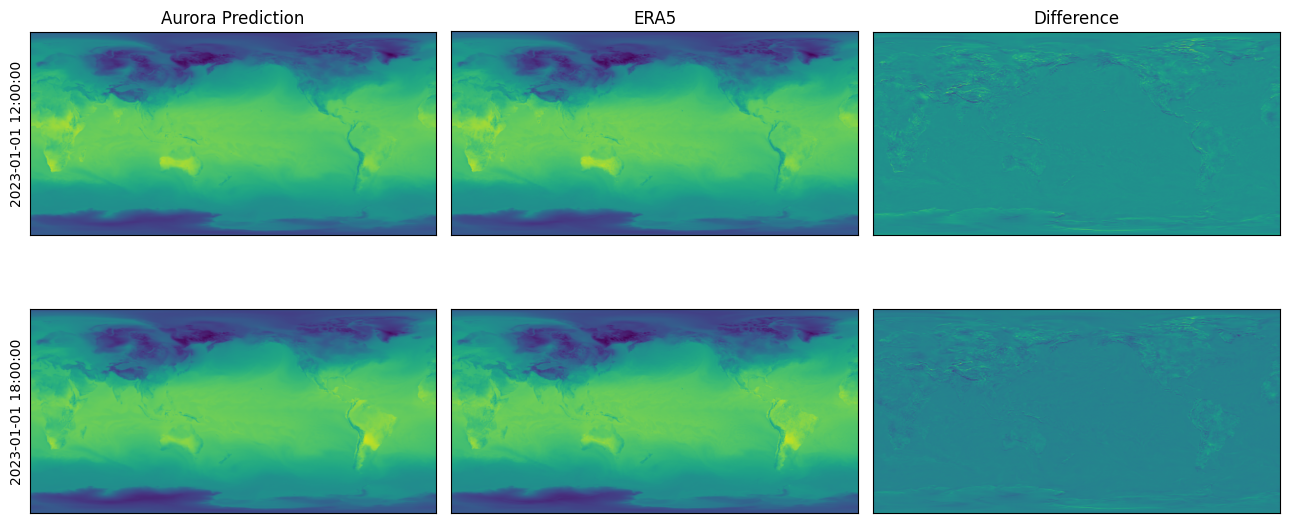

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(13, 6.5))

for i in range(ax.shape[0]):
    pred = preds[i]

    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ax[i, 1].imshow(surf_vars_ds["t2m"][2 + i].values - 273.15, vmin=-50, vmax=50)
    if i == 0:
        ax[i, 1].set_title("ERA5")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

    diff = pred.surf_vars["2t"][0, 0].numpy() - surf_vars_ds["t2m"][:,1:,:][2 + i].values
    ax[i, 2].imshow(diff)
    if i == 0:
        ax[i, 2].set_title("Difference")
    ax[i, 2].set_xticks([])
    ax[i, 2].set_yticks([])

plt.tight_layout()

In [29]:
# if run_on_foundry:
#     import logging
#     import os
#     import warnings

#     from aurora.foundry import BlobStorageChannel, FoundryClient, submit

#     # In this demo, we silence all warnings.
#     warnings.filterwarnings("ignore")

#     # But we do want to show what's happening under the hood!
#     logging.basicConfig(level=logging.WARNING, format="%(asctime)s [%(levelname)s] %(message)s")
#     logging.getLogger("aurora").setLevel(logging.INFO)

#     foundry_client = FoundryClient(
#         endpoint=os.environ["FOUNDRY_ENDPOINT"],
#         token=os.environ["FOUNDRY_TOKEN"],
#     )
#     channel = BlobStorageChannel(os.environ["BLOB_URL_WITH_SAS"])

#     predictions = list(
#         submit(
#             batch,
#             model_name="aurora-0.25-pretrained",
#             num_steps=2,
#             foundry_client=foundry_client,
#             channel=channel,
#         )
#     )